#  Import Libraries

In [ ]:
!pip install torch torchvision numpy matplotlib scikit-learn


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import os

# Dataset Preparation

**Define the transformations, dataset, and dataloader.**

In [3]:
# Define the transformations for the training and validation sets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets
train_dir = '/kaggle/input/vegetable-image-dataset/Vegetable Images/train'
val_dir = '/kaggle/input/vegetable-image-dataset/Vegetable Images/validation'
test_dir = '/kaggle/input/vegetable-image-dataset/Vegetable Images/test'

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Define Models 

**Define both models**

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load ResNet50 model
resnet50_model = models.resnet50(weights=None)
num_ftrs = resnet50_model.fc.in_features
resnet50_model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))  # Assuming the number of classes is equal to len(train_dataset.classes)

# Load VGG16 model
vgg16_model = models.vgg16(weights=None)
num_ftrs = vgg16_model.classifier[6].in_features
vgg16_model.classifier[6] = nn.Linear(num_ftrs, len(train_dataset.classes))  # Assuming the number of classes is equal to len(train_dataset.classes)

# Move models to device
resnet50_model = resnet50_model.to(device)
vgg16_model = vgg16_model.to(device)

criterion = nn.CrossEntropyLoss()

resnet50_optimizer = optim.SGD(resnet50_model.parameters(), lr=0.001, momentum=0.9)
vgg16_optimizer = optim.SGD(vgg16_model.parameters(), lr=0.001, momentum=0.9)


# Training Function 

**Define a function to train the models**

In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    best_model_wts = model.state_dict()
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'val':
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                best_model_wts = model.state_dict() if epoch_acc > max(val_acc_history, default=0) else best_model_wts
        
    print('Best val Acc: {:4f}'.format(max(val_acc_history, default=0)))
    model.load_state_dict(best_model_wts)
    
    return model, val_acc_history, train_loss_history, val_loss_history

# Train Models

In [6]:
resnet50_model, resnet50_val_acc_history, resnet50_train_loss_history, resnet50_val_loss_history = train_model(
    resnet50_model, train_loader, val_loader, criterion, resnet50_optimizer, num_epochs=10)

vgg16_model, vgg16_val_acc_history, vgg16_train_loss_history, vgg16_val_loss_history = train_model(
    vgg16_model, train_loader, val_loader, criterion, vgg16_optimizer, num_epochs=10)


Epoch 0/9
----------
train Loss: 2.1443 Acc: 0.2965
val Loss: 1.4101 Acc: 0.5047
Epoch 1/9
----------
train Loss: 1.0665 Acc: 0.6435
val Loss: 0.6824 Acc: 0.7717
Epoch 2/9
----------
train Loss: 0.5816 Acc: 0.8113
val Loss: 0.3695 Acc: 0.8943
Epoch 3/9
----------
train Loss: 0.3753 Acc: 0.8823
val Loss: 0.2160 Acc: 0.9367
Epoch 4/9
----------
train Loss: 0.2822 Acc: 0.9149
val Loss: 0.1711 Acc: 0.9530
Epoch 5/9
----------
train Loss: 0.2138 Acc: 0.9357
val Loss: 0.2319 Acc: 0.9393
Epoch 6/9
----------
train Loss: 0.1724 Acc: 0.9481
val Loss: 0.1276 Acc: 0.9637
Epoch 7/9
----------
train Loss: 0.1409 Acc: 0.9557
val Loss: 0.0836 Acc: 0.9737
Epoch 8/9
----------
train Loss: 0.1363 Acc: 0.9587
val Loss: 0.0984 Acc: 0.9720
Epoch 9/9
----------
train Loss: 0.1026 Acc: 0.9680
val Loss: 0.0654 Acc: 0.9793
Best val Acc: 0.979333
Epoch 0/9
----------
train Loss: 2.2468 Acc: 0.2282
val Loss: 1.7339 Acc: 0.3887
Epoch 1/9
----------
train Loss: 1.2595 Acc: 0.5698
val Loss: 1.0167 Acc: 0.6513
Epoch

# Evaluate Models

**Evaluate both models and visualize the results.**

In [7]:
def evaluate_model(model, dataloader):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for inputs, label in dataloader:
            inputs = inputs.to(device)
            label = label.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            labels.extend(label.cpu().numpy())
    return preds, labels

# Evaluate ResNet50
resnet50_preds, resnet50_labels = evaluate_model(resnet50_model, test_loader)
resnet50_acc = accuracy_score(resnet50_labels, resnet50_preds)
print(f'ResNet50 Accuracy: {resnet50_acc:.4f}')
print(classification_report(resnet50_labels, resnet50_preds, target_names=train_dataset.classes))

# Evaluate VGG16
vgg16_preds, vgg16_labels = evaluate_model(vgg16_model, test_loader)
vgg16_acc = accuracy_score(vgg16_labels, vgg16_preds)
print(f'VGG16 Accuracy: {vgg16_acc:.4f}')
print(classification_report(vgg16_labels, vgg16_preds, target_names=train_dataset.classes))


ResNet50 Accuracy: 0.9817
              precision    recall  f1-score   support

        Bean       0.98      0.97      0.98       200
Bitter_Gourd       0.98      0.98      0.98       200
Bottle_Gourd       0.99      0.99      0.99       200
     Brinjal       0.97      0.98      0.97       200
    Broccoli       0.98      0.98      0.98       200
     Cabbage       0.96      0.97      0.97       200
    Capsicum       0.97      0.99      0.98       200
      Carrot       0.99      0.99      0.99       200
 Cauliflower       0.97      0.98      0.98       200
    Cucumber       0.99      0.99      0.99       200
      Papaya       1.00      0.97      0.98       200
      Potato       1.00      0.98      0.99       200
     Pumpkin       0.99      0.95      0.97       200
      Radish       0.98      1.00      0.99       200
      Tomato       0.97      0.95      0.96       200

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000


# Visualize Results

**Visualize the confusion matrix and accuracy history.**

**Plot confusion matrix for ResNet50**

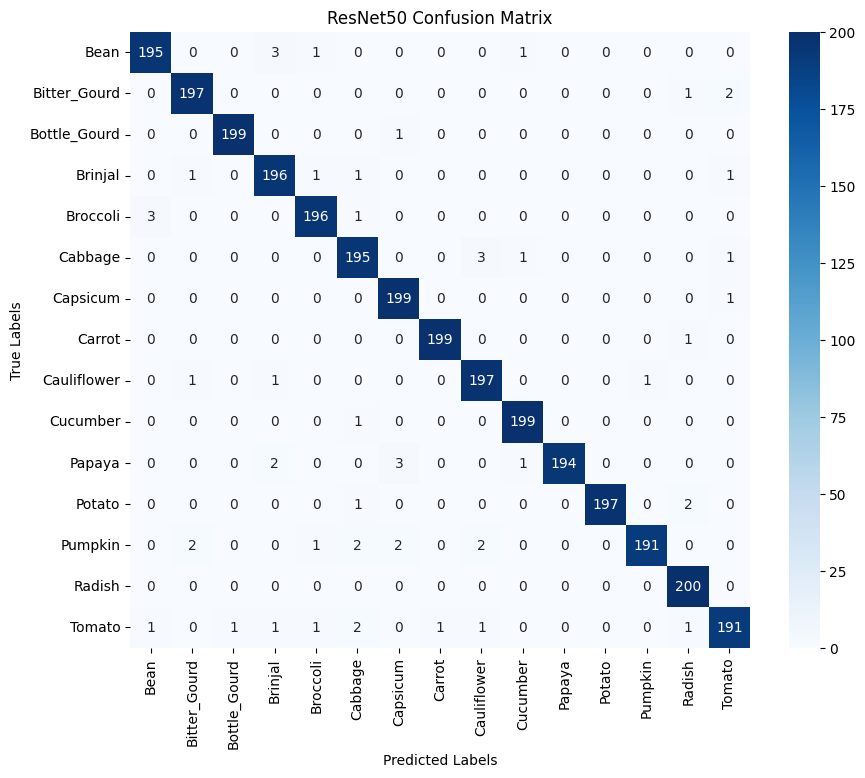

In [8]:
resnet50_cm = confusion_matrix(resnet50_labels, resnet50_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(resnet50_cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("ResNet50 Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

**Plot confusion matrix for VGG16**

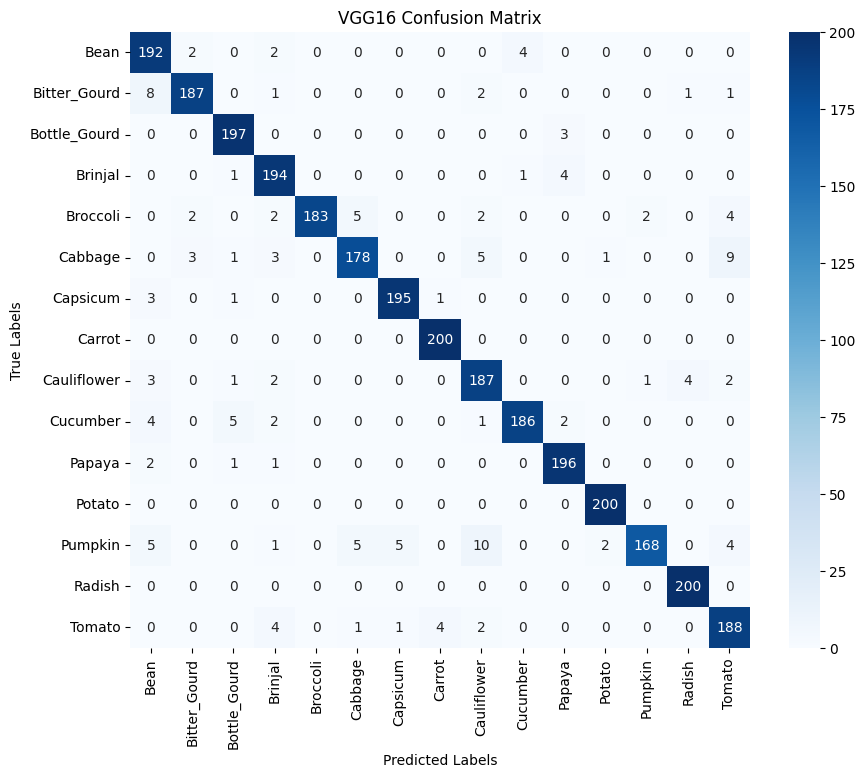

In [9]:
vgg16_cm = confusion_matrix(vgg16_labels, vgg16_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(vgg16_cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("VGG16 Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

**Plot accuracy history**

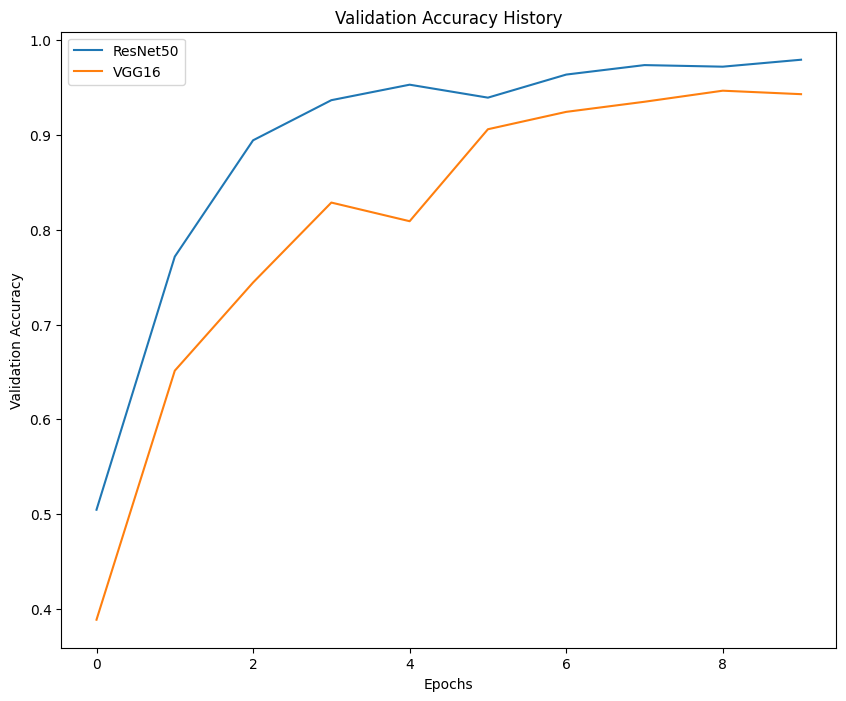

In [11]:
# Convert validation accuracy history to numpy arrays on CPU
resnet50_val_acc_history_cpu = [acc.cpu().numpy() for acc in resnet50_val_acc_history]
vgg16_val_acc_history_cpu = [acc.cpu().numpy() for acc in vgg16_val_acc_history]

# Plot validation accuracy history
plt.figure(figsize=(10, 8))
plt.plot(resnet50_val_acc_history_cpu, label='ResNet50')
plt.plot(vgg16_val_acc_history_cpu, label='VGG16')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy History')
plt.legend()
plt.show()


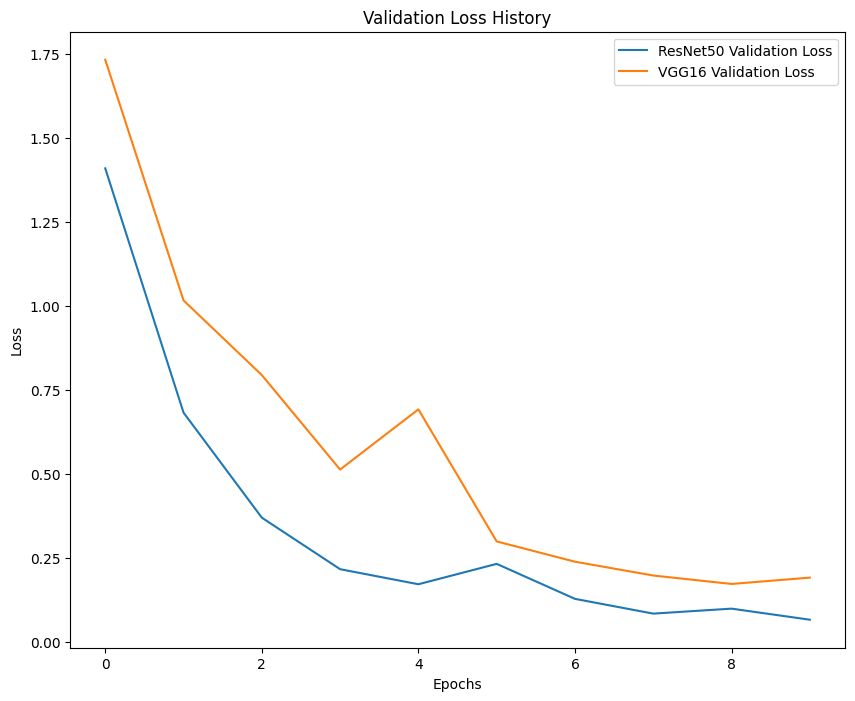

In [17]:
# Plot validation loss history
plt.figure(figsize=(10, 8))
plt.plot(resnet50_val_loss_history, label='ResNet50 Validation Loss')
plt.plot(vgg16_val_loss_history, label='VGG16 Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss History')
plt.legend()
plt.show()


**Visualize some sample predictions from both models along with their true labels.**

ResNet50 and VGG16 Predictions:


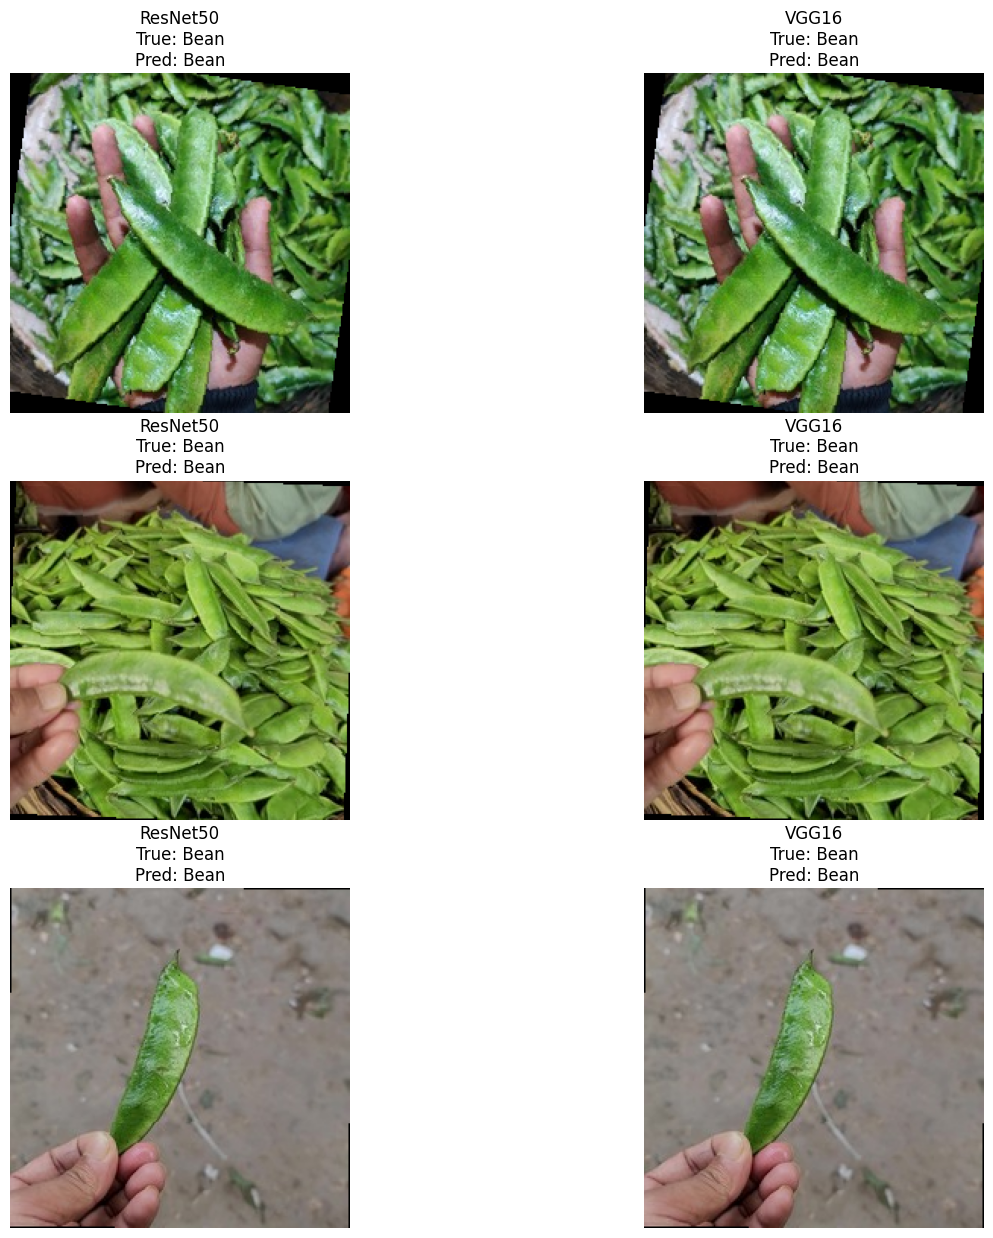

In [28]:
# Ensure device is set correctly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Function to visualize predictions for both ResNet50 and VGG16
def visualize_predictions(model_resnet50, model_vgg16, dataloader, class_names, num_images=6):
    model_resnet50.eval()
    model_vgg16.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Predictions for ResNet50
            outputs_resnet50 = model_resnet50(inputs)
            _, preds_resnet50 = torch.max(outputs_resnet50, 1)

            # Predictions for VGG16
            outputs_vgg16 = model_vgg16(inputs)
            _, preds_vgg16 = torch.max(outputs_vgg16, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'ResNet50\nTrue: {class_names[labels[j]]}\nPred: {class_names[preds_resnet50[j]]}')
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)
                ax.imshow(img)

                # Move to the next row for VGG16 predictions
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'VGG16\nTrue: {class_names[labels[j]]}\nPred: {class_names[preds_vgg16[j]]}')
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)
                ax.imshow(img)

                if images_so_far >= num_images:
                    return

# Visualize predictions for ResNet50 and VGG16 together
print("ResNet50 and VGG16 Predictions:")
visualize_predictions(resnet50_model, vgg16_model, test_loader, train_dataset.classes, num_images=6)
